In [9]:
import os
import sys
import errno
import re
import glob
import csv
import os.path as op
import json
import math
from datetime import datetime, timedelta, date
from IPython.display import display, clear_output, HTML
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as pltg
import seaborn as sn
from matplotlib.colors import LogNorm
import calendar
import pyproj
from pyproj import Proj, transform
import warnings
import rasterio
import pickle
from rasterio.warp import calculate_default_transform , reproject, Resampling 
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import mapping
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error
import geopandas as gpd
from calendar import isleap
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [10]:
def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return date
    
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile
# reproject the coord of a point from inEPSG to outEPSG
def reproject(inEPSG,outEPSG,x1,y1):  
    #transformer = Transformer.from_crs(int(inEPSG),int(outEPSG))
    #x2,y2 = transformer.transform(y1, x1)
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    #print("REPROJECT")
    #print(inEPSG,x1,y1)
    #print(outEPSG,x2,y2)
    return [x2, y2]

def getSPOTGRSFromStr(N):
    K = ''
    J = ''
    found = re.search('_'+'\d{3}'+'-' +'\d{3}'+'-'+'\d{1}', N)
    if found != None : 
        GRS = found.group(0)
        GRS_s = GRS.split('-')
        K = int(GRS_s[0][1:])
        J = int(GRS_s[1])
        S = int(GRS_s[2])
    
    return K,J,S

def getCoords(G):
    
    
    GT = G.GetGeoTransform()
    minx = GT[0]
    maxy = GT[3]
    maxx = minx + GT[1] * G.RasterXSize
    miny = maxy + GT[5] * G.RasterYSize
    
    return minx, maxy, maxx, miny

def get_station_data(station_id, min_year = 1985, max_year = 2019): 
    '''
    Returns a dataframe of the snow depth time series at this station
    '''
    f = glob(f'data/output_*_{int(station_id)}.txt')[0]
    df = pd.read_csv(f, delimiter=';', parse_dates=['Date'])
    df.rename(columns={"Date": "date"}, inplace=True)
    df.set_index('date',inplace=True)
    df = df.loc[f'{min_year}-09-01':f'{max_year}-08-31']
    df = add_waterdate(df)
    return df

def add_waterdate(df):
    '''
    Appends a water year column ('wy') to a series dataframe (index = date object) and other useful dates-related columns ('doy', 'dowy', 'datewy', etc.)
    '''
    dt = df.index
    df['date'] = dt
    df['doy'] = dt.dayofyear #day_of_year
    df['year'] = dt.year
    # add water year (labeled with 1st year of water year)
    df['wy'] = df[['doy','year']].apply(axis=1, func = lambda x: (x[1] - (x[0] < 244 + isleap(x[1]))), raw=True)
    df['dowy'] = df[['doy','year','wy']].apply(axis=1, func = lambda x: (x[0] + 122*(x[1] > x[2]) - (243+isleap(x[1]))*(x[1] == x[2])  ), raw=True) #day_of_wateryear
    return df.drop('date',axis=1)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [11]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}


epsg_list={
    "30TXN":{'EPSG':'32630'},
    '30TYN':{'EPSG':'32630'},
    '31TCH':{'EPSG':'32631'},
    '31TDH':{'EPSG':'32631'},
    "31TGJ":{'EPSG':'32631'},
    '31TGK':{'EPSG':'32631'},
    '31TGL':{'EPSG':'32631'},
    '31TGM':{'EPSG':'32631'},
    "32TLP":{'EPSG':'32632'},
    '32TLQ':{'EPSG':'32632'},
    '32TLR':{'EPSG':'32632'},
    '32TLS':{'EPSG':'32632'}
}


S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}


LANDSAT_tiles_2={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["200030","199030"],
        '30TYN':["200030","199030"],
        '31TCH':["199030","198031","198030"],
        '31TDH':["198031","198030","197031"]
    }
}

LANDSAT_tiles={
    "ALP":
    {
        "195029":["31TGJ",'31TGK','31TGL',"32TLP",'32TLQ','32TLR'],
        "195028":['31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "196029":["31TGJ",'31TGK','31TGL','32TLQ','32TLR'],
        "196028":['31TGK','31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "194029":["32TLP",'32TLQ','32TLR']
    },
    "PYR":
    {
        "200030":["30TXN",'30TYN'],
        "199030":["30TXN",'30TYN','31TCH'],
        "198031":['31TCH','31TDH'],
        "198030":['31TCH','31TDH'],
        "197031":['31TDH']
    }
}

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}
def get_station_data(station_id, min_year = 1985, max_year = 2019): 
    '''
    Returns a dataframe of the snow depth time series at this station
    '''
    f = glob.glob(f'/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/data/output_*_{int(station_id)}.txt')[0]
    df = pd.read_csv(f, delimiter=';', parse_dates=['Date'])
    df.rename(columns={"Date": "date"}, inplace=True)
    df.set_index('date',inplace=True)
    df = df.loc[f'{min_year}-09-01':f'{max_year}-08-31']
    df = add_waterdate(df)
    return df

def add_waterdate(df):
    '''
    Appends a water year column ('wy') to a series dataframe (index = date object) and other useful dates-related columns ('doy', 'dowy', 'datewy', etc.)
    '''
    dt = df.index
    df['date'] = dt
    df['doy'] = dt.dayofyear #day_of_year
    df['year'] = dt.year
    # add water year (labeled with 1st year of water year)
    df['wy'] = df[['doy','year']].apply(axis=1, func = lambda x: (x[1] - (x[0] < 244 + isleap(x[1]))), raw=True)
    df['dowy'] = df[['doy','year','wy']].apply(axis=1, func = lambda x: (x[0] + 122*(x[1] > x[2]) - (243+isleap(x[1]))*(x[1] == x[2])  ), raw=True) #day_of_wateryear
    return df.drop('date',axis=1)

In [12]:

points_shp_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/stations_tcd_50_massifs_prec4_nodoubles.shp"
srs =  osr.SpatialReference()
srs.ImportFromEPSG(4326)
drv = ogr.GetDriverByName( 'ESRI Shapefile' )
points_shp = drv.Open(points_shp_path)

layer_points = points_shp.GetLayer()
featureCount = layer_points.GetFeatureCount()
print(featureCount)


276


In [9]:
dict_tile_stations = {}

for f,feature in enumerate(layer_points):
    lon = feature['lon']
    lat = feature['lat']
    mtn = feature['mtn']
    print(f"parse stations {int(f/len(layer_points)*100)}%",end="                                               \r")
    for tile in S2_4326_tiles[mtn]:
        if lon > S2_4326_tiles[mtn][tile]["MAXX"] or lon < S2_4326_tiles[mtn][tile]["MINX"] or \
        lat > S2_4326_tiles[mtn][tile]["MAXY"] or lat < S2_4326_tiles[mtn][tile]["MINY"] : continue
        if tile not in dict_tile_stations : dict_tile_stations[tile] = []
        to_tile = pyproj.Transformer.from_crs(4326,int(epsg_list[tile]['EPSG']), always_xy=True)
        coord = to_tile.itransform([(lon,lat)]) 
        list_coord = [*coord] #only one coord
        dict_tile_stations[tile].append((feature,list_coord,get_station_data(feature['station id'], min_year = 1985, max_year = 2015)))

In [10]:
SWH_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/TCD-BLUE_AVG-1200"
list_swh_dates = list(dict.fromkeys(
[date(int(x.split("/")[-3]),int(x.split("/")[-2]),int(x.split("/")[-1])) for x in glob.glob(os.path.join(SWH_path,'*','*','*','*','*'))]))

In [11]:
DLR_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
list_dlr_dates = list(dict.fromkeys(
[getDateFromStr(x) for x in glob.glob(os.path.join(DLR_path,'*','*'))]))

In [14]:
#get days of spot acqui per month/year/station...

SWH_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/TCD-BLUE_AVG-1200"
df_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_acquis_stations.pkl"
dict_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/dict_swh_acquis_stations.json"


d = dict()
d["ID"] = []
d["YEAR"] = []
d["MONTH"] = []
d["DAY"] = []
d["MTN"] = []
d["TILE"] = []
d["SAFRAN"] = []
d["SAFRAN_S"] = []
d["CLASS"] = []
d["SD_SIM"] = []
d["SD_OBS"] = []
nb_dates = len(list_swh_dates)
count = 0
for mtn in S2_4326_tiles:
    for tile in S2_4326_tiles[mtn]:
        for j,single_date in enumerate(list_swh_dates):
            year = single_date.year
            month = single_date.month
            day = single_date.day
            #get list of swh products
            print(f"{mtn} {tile} {int(j/nb_dates*100)}%  {count}",end="                                               \r")
            list_swh = glob.glob(os.path.join(SWH_path,mtn,'*',str(year),str(month),str(day),"*",tile,"*","*FSCTOC*"),recursive=True)
            if not list_swh: continue
            #get list of stations with data at that date for that tile
            list_stations = []
            v = 0
            for feature,list_coord,station_df in dict_tile_stations[tile]:
                v+=1
                #print(f"find stations {mtn} {tile} {day}/{month}/{year} {int(v/len(dict_tile_stations[tile])*100)}% {count}",end="                                               \r")
                try:
                    sd_sim = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_Crocus_assim']
                    sd_obs = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_obs']
                    list_stations.append((feature,list_coord,sd_sim,sd_obs))
                except KeyError:
                    continue
            if not list_stations : continue
            #get hydro date
            if single_date < date(int(single_date.year),9,1):
                annee_hydro = int(single_date.year) - 1
            else:
                annee_hydro = int(single_date.year)
            date_debut_hydro = date(annee_hydro,9,1)
            annee_hydro_jour = (single_date - date_debut_hydro).days + 1
            #check for swh/stations pairs
            for k,swh in enumerate(list_swh):
                #show progress
                #print(f"find pairs {mtn} {tile} {day}/{month}/{year} {int(k/len(list_swh)*100)}% {count}",end="                                               \r")
                with rasterio.open(swh) as src:
                    for feature,list_coord,sd_sim,sd_obs in list_stations:
                        for z in src.sample(list_coord,masked=True): 
                            if z[0] != '--' : 
                                pixel = float(z[0])
                                #print(pixel)
                                if pixel != 255 :
                                    d["YEAR"].append(annee_hydro)
                                    d["DAY"].append(annee_hydro_jour)
                                    d["MONTH"].append(month)
                                    d["TILE"].append(tile)
                                    d["MTN"].append(mtn)
                                    d["SAFRAN"].append(feature['title'])
                                    d["ID"].append(feature['station id'])
                                    d["SAFRAN_S"].append(feature['title_s'])
                                    d["CLASS"].append(pixel)
                                    d["SD_SIM"].append(sd_sim)
                                    d["SD_OBS"].append(sd_obs)
                                    count+=1
                                    
df = pd.DataFrame(data=d)   
df = df.drop_duplicates()
df["COLLECTION"]="SWH"
df.to_pickle(df_swh_path)

In [15]:
#get days of landsat acqui per month/year/station...

DLR_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
df_dlr_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_landsat_acquis_stations.pkl"


d = dict()
d["ID"] = []
d["YEAR"] = []
d["MONTH"] = []
d["DAY"] = []
d["MTN"] = []
d["TILE"] = []
d["SAFRAN"] = []
d["SAFRAN_S"] = []
d["CLASS"] = []
d["SD_SIM"] = []
d["SD_OBS"] = []
nb_dates = len(list_dlr_dates)
count = 0
for mtn in S2_4326_tiles:
    for wrs in LANDSAT_tiles[mtn]:
        for j,single_date in enumerate(list_dlr_dates):
            str_date = single_date.strftime("%Y%m%d")
            year = single_date.year
            month = single_date.month
            day = single_date.day
            #get hydro date
            if single_date < date(int(single_date.year),9,1):
                annee_hydro = int(single_date.year) - 1
            else:
                annee_hydro = int(single_date.year)
            date_debut_hydro = date(annee_hydro,9,1)
            annee_hydro_jour = (single_date - date_debut_hydro).days + 1
            #get list of dlr products
            print(f"{mtn} {wrs} {int(j/nb_dates*100)}%  {count}",end="                                               \r")
            list_dlr = glob.glob(os.path.join(DLR_path,mtn+"_LIS",f"FSC_{str_date}T*_{wrs}",f"FSC_{str_date}T*_{wrs}_FSCTOC.tif"),recursive=True)
            if not list_dlr: continue
            for dlr in list_dlr:
                for tile in LANDSAT_tiles[mtn][wrs]:
                    #get list of stations with data at that date for that tile
                    list_stations = []
                    v = 0
                    for feature,list_coord,station_df in dict_tile_stations[tile]:
                        v+=1
                        #print(f"find stations {mtn} {tile} {day}/{month}/{year} {int(v/len(dict_tile_stations[tile])*100)}% {count}",end="                                               \r")
                        try:
                            sd_sim = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_Crocus_assim']
                            sd_obs = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_obs']
                            list_stations.append((feature,list_coord,sd_sim,sd_obs))
                        except KeyError:
                            continue
                    if not list_stations : continue
                    #print(f"find pairs {mtn} {tile} {day}/{month}/{year} {int(k/len(list_swh)*100)}% {count}",end="                                               \r")
                    with rasterio.open(dlr) as src:
                        for feature,list_coord,sd_sim,sd_obs in list_stations:
                            for z in src.sample(list_coord,masked=True): 
                                if z[0] != '--' : 
                                    pixel = float(z[0])
                                    #print(pixel)
                                    if pixel != 255 :
                                        d["YEAR"].append(annee_hydro)
                                        d["DAY"].append(annee_hydro_jour)
                                        d["MONTH"].append(month)
                                        d["TILE"].append(tile)
                                        d["MTN"].append(mtn)
                                        d["SAFRAN"].append(feature['title'])
                                        d["ID"].append(feature['station id'])
                                        d["SAFRAN_S"].append(feature['title_s'])
                                        d["CLASS"].append(pixel)
                                        d["SD_SIM"].append(sd_sim)
                                        d["SD_OBS"].append(sd_obs)
                                        count+=1
                                    
df = pd.DataFrame(data=d)   
df = df.drop_duplicates()
df["COLLECTION"]="LANDSAT"
df.to_pickle(df_dlr_path)

In [47]:
df_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_acquis_stations.pkl"
df_dlr_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_landsat_acquis_stations.pkl"
df_both_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_landsat_acquis_stations.pkl"

#causes de doublons:
# 1) stations dans zones chevauchement de tuile S2 ou wrs
# 2) meme date Landsat et SWH
# 3) risques que class ait différente valeur selon la tuile ou le satellite 

with open( df_swh_path, "rb" )  as f1, open( df_dlr_path, "rb" )  as f2:
    df = pd.concat([pickle.load(f1),pickle.load(f2)],ignore_index=True)
df["MONTH_N"] = df["MONTH"] 
print(df["CLASS"].unique())
df["MONTH"] = df['MONTH'].apply(lambda m: calendar.month_abbr[m])
df["CLASS"]= np.where(df['CLASS'] == 205.0, 'CLOUD', np.where(df['CLASS'] == 100.0, 'SNOW', 'GROUND'))
df.to_pickle(df_both_path)  #dataframe de stations par tuile (donc doublons dans les chevauchement
print(df["CLASS"].unique())

[  0. 205. 100.]
['GROUND' 'CLOUD' 'SNOW']


In [13]:
df_both_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_landsat_acquis_stations.pkl"
with open( df_both_path, "rb" )  as dp:
    df = pickle.load(dp)
df_u_sta_sat = df.loc[df.drop(columns=["TILE","CLASS"]).drop_duplicates().index]  
df_u_sta = df.loc[df.drop(columns=["TILE","CLASS","COLLECTION"]).drop_duplicates().index]  
print(df_u_sta_sat)
print(df_u_sta)

              ID  YEAR MONTH  DAY  MTN   TILE           SAFRAN SAFRAN_S  \
0       64316002  2002   Jul  322  PYR  30TXN      Pays-Basque    P-Bas   
1       64316400  2002   Jul  322  PYR  30TXN      Pays-Basque    P-Bas   
2       64316002  2002   Jul  312  PYR  30TXN      Pays-Basque    P-Bas   
3       64316400  2002   Jul  312  PYR  30TXN      Pays-Basque    P-Bas   
4       64316002  2002   Jun  280  PYR  30TXN      Pays-Basque    P-Bas   
...          ...   ...   ...  ...  ...    ...              ...      ...   
781434  73023001  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781435  73322401  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781436  73157002  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781437  73026001  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781438  73157400  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   

         CLASS  SD_SIM  SD_OBS COLLECTION  MONTH_N  
0       GROUND     0.0     0.0        SWH     

['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
       MTN MONTH         ID  YEAR  MEAN ACQUISITION COUNT
0      ALP   Apr    4006004  1986                       5
1      ALP   Apr    4006004  1987                       2
2      ALP   Apr    4006004  1988                       3
3      ALP   Apr    4006004  1989                       4
4      ALP   Apr    4006004  1990                       5
...    ...   ...        ...   ...                     ...
95001  PYR   Sep  203025064  2010                       3
95002  PYR   Sep  203025064  2011                       5
95003  PYR   Sep  203025064  2012                       1
95004  PYR   Sep  203025064  2013                       5
95005  PYR   Sep  203025064  2014                       7

[95006 rows x 5 columns]
      MTN         ID  YEAR  MEAN ACQUISITION COUNT
0     ALP    4006004  1986                      58
1     ALP    4006004  1987                      51
2     ALP    4006004  1988              

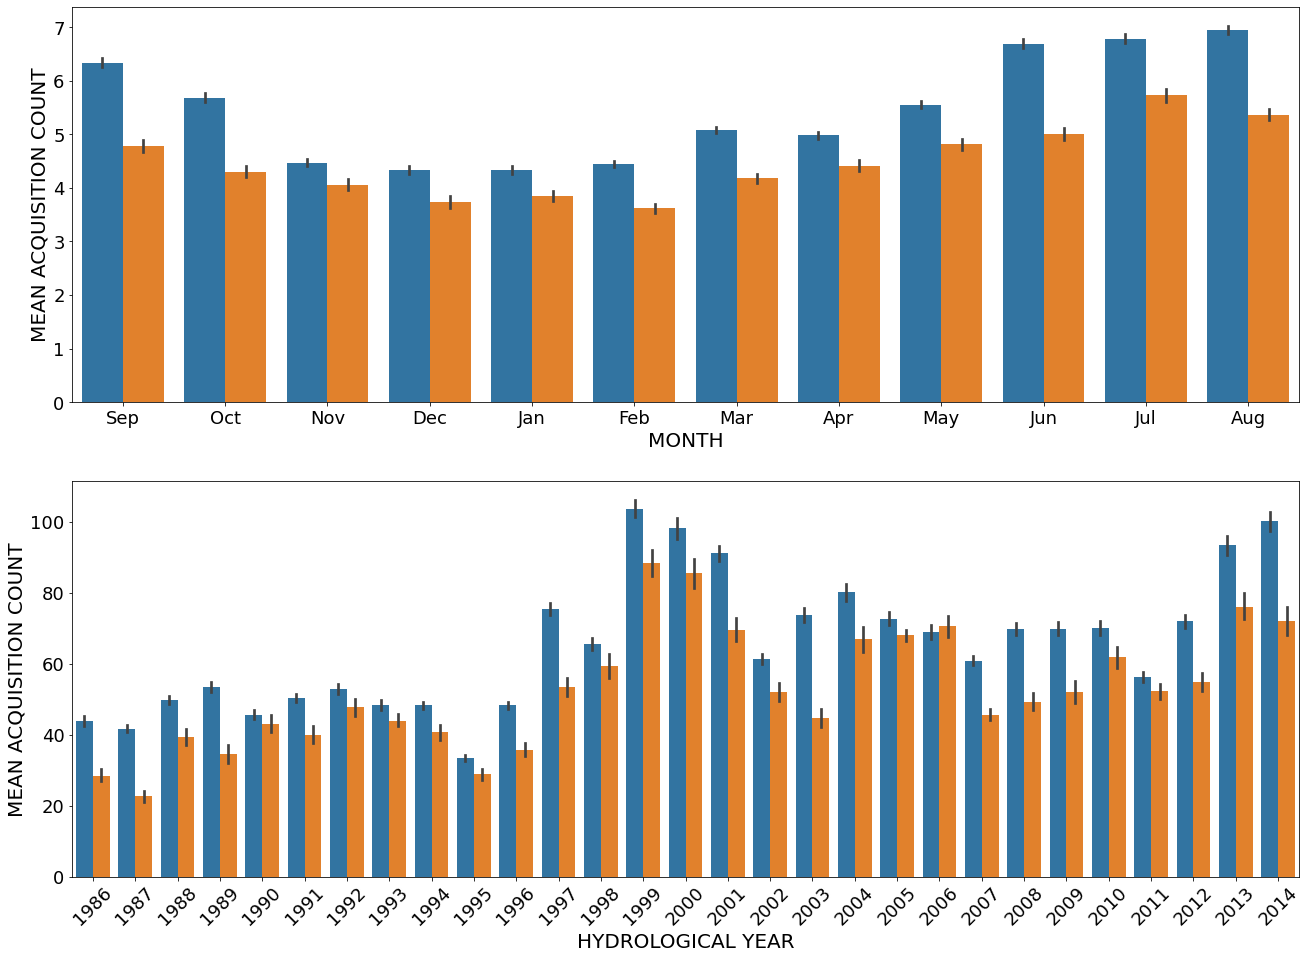

In [14]:
plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

month_hydro_order = calendar.month_abbr[9:]+calendar.month_abbr[1:9]
print(month_hydro_order)


df_temp1 = df_u_sta.query("YEAR > 1985 ").groupby(["MTN","MONTH","ID","YEAR"])["DAY"].count().to_frame("MEAN ACQUISITION COUNT").reset_index()
df_temp2 = df_u_sta.query("YEAR > 1985").groupby(["MTN","ID","YEAR"])["DAY"].count().to_frame("MEAN ACQUISITION COUNT").reset_index()
print(df_temp1)
print(df_temp2)
#df_temp2 = df_all.groupby(["MTN","MONTH","ID","YEAR"])["DAY"].count().to_frame("ACQUISITION COUNT").reset_index()





fig, axs = plt.subplots(2)
sn.barplot(ax=axs[0],data=df_temp1.set_index("MONTH").loc[month_hydro_order].reset_index(),x='MONTH',y='MEAN ACQUISITION COUNT',hue='MTN')
axs[0].set_ylabel("MEAN ACQUISITION COUNT",size=20)
axs[0].set_xlabel("MONTH",size=20)
axs[0].legend_.remove()
axs[0].tick_params(axis='both', which='major', labelsize=18)
sn.barplot(ax=axs[1],data=df_temp2,x='YEAR',y='MEAN ACQUISITION COUNT',hue='MTN')
axs[1].set_ylabel("MEAN ACQUISITION COUNT",size=20)
axs[1].set_xlabel("HYDROLOGICAL YEAR",size=20)
axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[1].legend_.remove()
plt.xticks(rotation = 45)
fig.set_figwidth(22)
fig.set_figheight(16)
plt.savefig(op.join(plot_path,f'stations_acqui.svg'),format="svg")

In [38]:
df_clouds = df_u_sta.query(
    "YEAR > 1985"
).groupby(["MTN","MONTH"])["CLASS"].count().to_frame("CLASS%").reset_index()
#df_clouds = ((df_u_sta.query("YEAR > 1985 & (SD_OBS > 0.01 | SD_OBS > 0.01 )").groupby(["MTN","MONTH"])['CLASS'].value_counts()/df_u_sta.query("YEAR > 1985 & (SD_OBS > 0.01 | SD_OBS > 0.01 )").groupby(["MTN","MONTH"])['CLASS'].count()) * 100).to_frame("CLASS%").reset_index()
print(df_clouds)

#sn.kdeplot(data=df_clouds.query("CLASS == 'CLOUD'"),hue="MTN",x="DAY",y="CLASS%")

    MTN MONTH  CLASS%
0   ALP   Apr   27715
1   ALP   Aug   38675
2   ALP   Dec   23657
3   ALP   Feb   24760
4   ALP   Jan   23917
5   ALP   Jul   37776
6   ALP   Jun   37261
7   ALP   Mar   28304
8   ALP   May   30942
9   ALP   Nov   24629
10  ALP   Oct   31443
11  ALP   Sep   35268
12  PYR   Apr   10384
13  PYR   Aug   13063
14  PYR   Dec    8300
15  PYR   Feb    8693
16  PYR   Jan    8760
17  PYR   Jul   13932
18  PYR   Jun   12110
19  PYR   Mar    9889
20  PYR   May   11375
21  PYR   Nov    9713
22  PYR   Oct   10384
23  PYR   Sep   11534


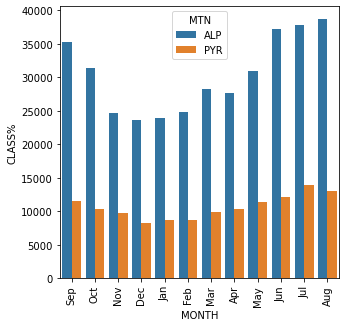

In [39]:
fig, axs = plt.subplots()
month_hydro_order = calendar.month_abbr[9:]+calendar.month_abbr[1:9]
sn.barplot(ax=axs,data=df_clouds.set_index("MONTH").loc[month_hydro_order].reset_index(),x="MONTH",y="CLASS%",hue='MTN')
plt.xticks(rotation = 90)
fig.set_figwidth(5)
fig.set_figheight(5)

In [ ]:
# make monthly distribution of nb of acquisitions 
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_landsat_acquis.pkl"
with open( df_path, "rb" )  as df:
    df = pickle.load(df)

df_temp = df.query("YEAR >= 1986 & YEAR < 2015")
df_temp = df_temp[["MONTH","MTN","ID"]].groupby([])

df = df.drop_duplicates()

df["ACQUI"]  =1
df_minmax = df[["YEAR","ID","ACQUI"]].groupby(["YEAR","ID"], as_index=False).sum()


min_obs = df_minmax["ACQUI"].min()
max_obs = df_minmax["ACQUI"].max()
print(min_obs,max_obs)

df_seasons = df[["SEASON","ID","ACQUI"]].groupby(["SEASON","ID"], as_index=False).sum()
fig, ax = plt.subplots()
sn.boxplot(data = df_seasons, x = "SEASON",y="ACQUI",order=["AUTUMN","WINTER","SPRING","SUMMER"])
plt.savefig("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/PLOTS/seasons.pdf",format="pdf")

df = df_seasons[["SEASON","ACQUI"]].groupby(["SEASON"], as_index=False).median()
df["WEIGHT"] = df["ACQUI"]/df["ACQUI"].sum()
dict_weights = dict(zip(df["SEASON"], df["WEIGHT"]))
        
print(dict_weights)

In [ ]:
# make seasonal weigth range and get min and max NOBS
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_landsat_acquis.pkl"
with open( df_path, "rb" )  as df:
    df = pickle.load(df)

df = df.query("YEAR >= 1986 & YEAR < 2015")
df = df[["YEAR","SEASON","DAY","ID"]]

df = df.drop_duplicates()

df["ACQUI"]  =1
df_minmax = df[["YEAR","ID","ACQUI"]].groupby(["YEAR","ID"], as_index=False).sum()


min_obs = df_minmax["ACQUI"].min()
max_obs = df_minmax["ACQUI"].max()
print(min_obs,max_obs)

df_seasons = df[["SEASON","ID","ACQUI"]].groupby(["SEASON","ID"], as_index=False).sum()
fig, ax = plt.subplots()
sn.boxplot(data = df_seasons, x = "SEASON",y="ACQUI",order=["AUTUMN","WINTER","SPRING","SUMMER"])
plt.savefig("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/PLOTS/seasons.pdf",format="pdf")

df = df_seasons[["SEASON","ACQUI"]].groupby(["SEASON"], as_index=False).median()
df["WEIGHT"] = df["ACQUI"]/df["ACQUI"].sum()
dict_weights = dict(zip(df["SEASON"], df["WEIGHT"]))
        
print(dict_weights)